In [2]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
sns.set(color_codes=True)

In [3]:
from libs import utils 

In [4]:
import random

In [ ]:
%ñs /home/outputs

In [5]:
path_csv = "../actas-de-mesa/results/"

csv_files = glob.glob(path_csv + "*.txt")

print(f"TOTAL ACTAS TO PROCESS: {len(csv_files)}")

TOTAL ACTAS TO PROCESS: 3


In [6]:
my_error_boxes = csv_files[2]

In [7]:
df = pd.read_csv(my_error_boxes, names=["file_name", "boxes"] )
df.head()

,file_name,boxes
0,/home/actas/339251.jpg,12
1,/home/actas/770831.jpg,25
2,/home/actas/347511.jpg,12
3,/home/actas/260401.jpg,0
4,/home/actas/243221.jpg,0


TOTAL ACTAS DEBUG 12598


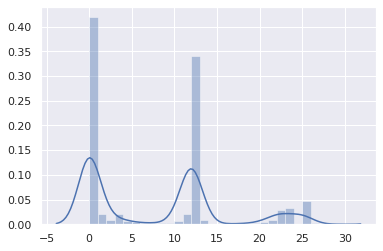

In [8]:
u_actas_debug = np.unique(df["file_name"])

print(f"TOTAL ACTAS DEBUG {len(u_actas_debug)}")
boxes_c = list(df["boxes"])
sns.distplot(boxes_c);

In [9]:
uniques = np.unique(boxes_c)

In [10]:
counts = []
keys = uniques
values = []

for u in uniques:
    counts.append({u : boxes_c.count(u)})
    values.append( boxes_c.count(u))
    

In [11]:
df_lists = []
for u in uniques:
    df_lists.append({u:[]})
    

print(df_lists)

[{0: []}, {1: []}, {2: []}, {3: []}, {4: []}, {5: []}, {6: []}, {7: []}, {8: []}, {9: []}, {10: []}, {11: []}, {12: []}, {13: []}, {14: []}, {15: []}, {16: []}, {17: []}, {18: []}, {19: []}, {20: []}, {21: []}, {22: []}, {23: []}, {25: []}, {26: []}, {27: []}, {28: []}]


In [12]:
for _df in df_lists:
    for k, v in _df.items():
        _aux_df = df[df["boxes"] == k]
        v.append(_aux_df)



In [13]:
def query_df(key):
    return df_lists[key][key][0]


In [14]:
df_0 = query_df(0)

In [15]:
df_0.head()

,file_name,boxes
3,/home/actas/260401.jpg,0
4,/home/actas/243221.jpg,0
7,/home/actas/212361.jpg,0
8,/home/actas/22411.jpg,0
9,/home/actas/255111.jpg,0


In [16]:
df_0.shape

(5276, 2)

In [17]:
r_number = random.randint(0, df.shape[0])
img_name = df["file_name"][r_number -1]
value =  df["boxes"][r_number - 1]
print(img_name, value )


/home/actas/240011.jpg 9


In [18]:
# Aux functinos

P1 = (90*4, 98*4)
P2 = (272*4, 218*4)

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,0,255)
lineType               = 2


def find_contour_base(image, kernel):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

    #--- performing Otsu threshold ---
    ret,thresh1 = cv2.threshold(gray, 0, 255, 
                                cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    #--- choosing the right kernel
    #--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
    #--- and 10 columns to join neighboring letters in words and neighboring words
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    #---Finding contours ---
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im2 = image.copy()

    return im2, contours
        
def find_contour(image, image_path=""):
    
    #(30, 2) for letters
    im2, contours = find_contour_base(image, (7,2))

    boxes = []
    outputs =[]

    # Iterate over all contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        p1 = (x, y)
        p2 = (x + w, y + h)

        deltax = p2[0]-p1[0]
        deltay = p2[1]-p1[1]

        if (200<=(deltax)<=360) and (30<=(deltay)<=70):
            # print(deltax)
            # print(deltay)
            p1 = (p1[0], p1[1])
            p2 = (p2[0] + 210*0, p2[1])

            boxes.append([p1,p2])

            cv2.rectangle(im2, p1, p2, (0, 255, 0), 2)

    size = len(boxes)
    print(f"TOTAL BOXES {size}")

    # If all the rectanguler boxes was found.
    if size == 24:
        # print("size",size)

        # Iterate over the rectangular boxes
        for i, b in enumerate(boxes):

            partido_id = str(i+1)

            outputs.append({i+1: b})


            cv2.putText(im2, partido_id, tuple(b[0]), 
                                            font, 
                                            fontScale,
                                            fontColor,
                                            lineType)
    else:
        """
        If detection is < 24 log this file
        """
        file_name = "detect_boxes_error_log"
        print(f"ERROR BOxes {file_name} - {size}")
    return im2, outputs


def norm_image(image):
    """
    Norm image to constant shape
    """
    img = cv2.resize(image, (2500, 1600))
    return img

def cut_image(image, p1, p2, simple=False):
    """
    Crop any imagen given P1 and P2
    """
    x = p1[0]
    y = p1[1]

    w = p2[0]
    h = p2[1]

    if simple:
        crop_img = image[y:h, x:w]
    crop_img = image[y:y+h, x:x+w]
    return crop_img

def show_image(file_name, full=False):
    
    img = cv2.imread(file_name)
    
    if full:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_r   =  norm_image(img)
        # extract only the votation box
        c_image =   cut_image(img_r, P1, P2)

        cont_img,  outputs = find_contour(c_image)

        plt.figure(figsize=(10,10))
        plt.imshow(cont_img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10,10))
        plt.imshow(img)

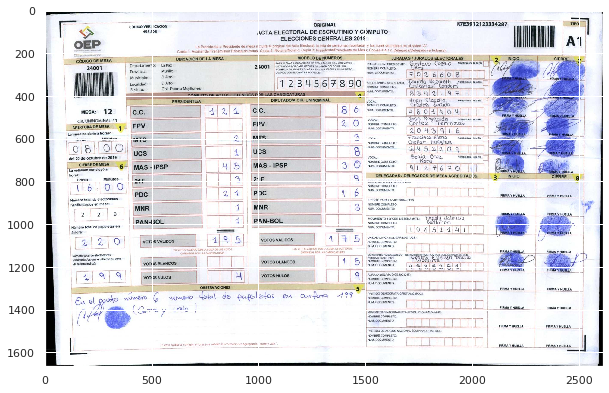

In [19]:
show_image(img_name, full=False)

In [20]:
my_files = list(df["file_name"])
print(my_files[:10])

['/home/actas/339251.jpg', '/home/actas/770831.jpg', '/home/actas/347511.jpg', '/home/actas/260401.jpg', '/home/actas/243221.jpg', '/home/actas/19571.jpg', '/home/actas/335301.jpg', '/home/actas/212361.jpg', '/home/actas/22411.jpg', '/home/actas/255111.jpg']


In [21]:
fixed = []
for f in my_files:
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_r   =  norm_image(img)
    # extract only the votation box
    c_image =   cut_image(img_r, P1, P2)
    cont_img,  outputs = find_contour(c_image)
    
    if len(outputs) == 24:
        fixed.append({f: outputs})
    else:
        print(f)
    
    
    

TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/339251.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/347511.jpg
TOTAL BOXES 25
ERROR BOxes detect_boxes_error_log - 25
/home/actas/260401.jpg
TOTAL BOXES 24
TOTAL BOXES 10
ERROR BOxes detect_boxes_error_log - 10
/home/actas/19571.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/335301.jpg
TOTAL BOXES 24
TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/22411.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/781821.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/903161.jpg
TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/17741.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/320911.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/335711.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
T

TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/24021.jpg
TOTAL BOXES 15
ERROR BOxes detect_boxes_error_log - 15
/home/actas/358121.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/348061.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 22
ERROR BOxes detect_boxes_error_log - 22
/home/actas/704331.jpg
TOTAL BOXES 24
TOTAL BOXES 22
ERROR BOxes detect_boxes_error_log - 22
/home/actas/737451.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/324531.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/306261.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/318571.jpg
TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/18711.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/332071.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/344421.jpg
TOTAL BOXES 24
TOTAL BOXES 3
ERROR BOxes detect_boxes_erro

TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/302311.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/341601.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/314451.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/322271.jpg
TOTAL BOXES 24
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/769071.jpg
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/11161.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/342391.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/314481.jpg
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/277821.jpg
TOTAL BOXES 24
TOTAL BOXES 23
ERROR BOxes detect_boxes_error_log - 23
/home/actas/902311.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/304871.jpg

TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/308551.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/345841.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/310391.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/348901.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/276751.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/313641.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/301231.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/325561.jpg
TOTAL BOXES 8
ERROR BOxes detect_boxes_error_log - 8
/home/actas/279151.jpg
TOTAL BOXES 24
TOTAL BOXES 11
ERROR BOxes detect_boxes_error_log - 11
/home/actas/320621.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/330291.

TOTAL BOXES 20
ERROR BOxes detect_boxes_error_log - 20
/home/actas/506281.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/342691.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/316901.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/301801.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 10
ERROR BOxes detect_boxes_error_log - 10
/home/actas/332271.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/314761.jpg
TOTAL BOXES 20
ERROR BOxes detect_boxes_error_log - 20
/home/actas/240441.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/335521.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/311821.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/317931.jpg
TOTAL BOXES 24
TOTAL BOXES 23
ERROR BOxes detect_boxes_error_log - 23
/home/actas/800421.jpg
TOTAL BOXES 12
ERROR B

TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/321931.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/318791.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/332221.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/309391.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/328761.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 23
ERROR BOxes detect_boxes_error_log - 23
/home/actas/231811.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/306701.jpg
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/613171.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/307091.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/306051.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/32236

TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/327921.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/329961.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/337041.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/311551.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 4
ERROR BOxes detect_boxes_error_log - 4
/home/actas/278101.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/312251.jpg
TOTAL BOXES 24
TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/243171.jpg
TOTAL BOXES 22
ERROR BOxes detect_boxes_error_log - 22
/home/actas/360611.jpg
TOTAL BOXES 24
TOTAL BOXES 23
ERROR BOxes detect_boxes_error_log - 23
/home/actas/216961.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 23
ERROR BOxes detect_boxes_error_log - 23
/home/actas/804201.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 23

TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/309421.jpg
TOTAL BOXES 24
TOTAL BOXES 24
TOTAL BOXES 0
ERROR BOxes detect_boxes_error_log - 0
/home/actas/20601.jpg
TOTAL BOXES 3
ERROR BOxes detect_boxes_error_log - 3
/home/actas/11501.jpg
TOTAL BOXES 24
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/318241.jpg
TOTAL BOXES 22
ERROR BOxes detect_boxes_error_log - 22
/home/actas/744611.jpg
TOTAL BOXES 12
ERROR BOxes detect_boxes_error_log - 12
/home/actas/312801.jpg


KeyboardInterrupt: 

In [ ]:
print(len(my_files))

In [56]:
import pickle


In [60]:
# Save the fixed list into pkl file
fixed_list = []

for f in fixed:
    for k, v in f.items():
        fixed_list.append(k)
        
print(len(fixed_list))
print(fixed_list[:2])

5094
['/home/actas/243221.jpg', '/home/actas/212361.jpg']


In [61]:
# define a list of places

with open('fixed_list.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(fixed_list, filehandle)


In [62]:
%ls

 acta.2019.10.22.22.29.53.xlsx       metadata_images_computo.csv
 acta.2019.10.25.10.13.40.xlsx       models/
'acta.2019.10.25.21.09.30(1).xlsx'   montage.png
 actas-an-extract-metadata.ipynb     output/
 badImagesList.np.npy                Pixel_wise_ana.ipynb
 dataset/                            rawMetadata.np.npy
 dataset_2/                          results/
 dataset_p_actas.png                 test/
 fixed_list.data                     test_custom_mnist_creation.ipynb
'Handle 40%.ipynb'                   train_reset.ipynb
 libs/


In [63]:
with open('fixed_list.data', 'rb') as filehandle:
    # read the data as binary data stream
    placesList = pickle.load(filehandle)

In [64]:
placesList[:3]

['/home/actas/243221.jpg', '/home/actas/212361.jpg', '/home/actas/255111.jpg']

TOTAL BOXES 24


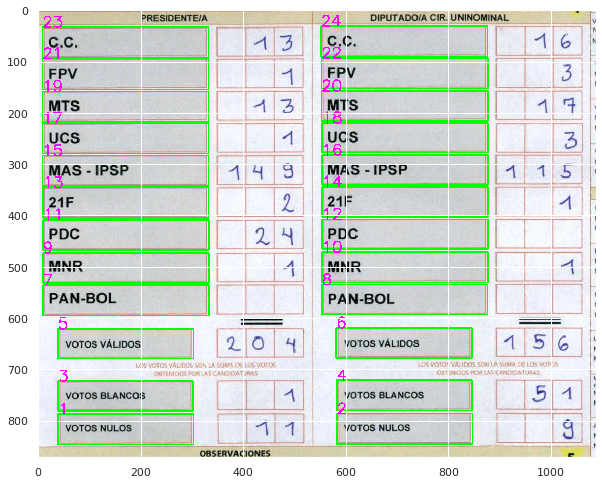

In [54]:
show_image("/home/actas/243221.jpg", full=True)